In [1]:
import preprocess
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")

In [2]:
def prepre(df):
    df = df.drop(['Date of Discharge', 'Chronic disease',
           'Immune status', 'Foley days', 'CVC days', 'Palliative', 'PH', 
           'Vent days', 'TWA Glucose', 'LOS', 'APACHE II Pred Mort', 'Trop Pred Mort'], axis=1)
    df['Vent mode'] = np.nan
    df['A-a gradient'] = np.nan
    df = df[['Unnamed: 0.1', 'Name', 'CPMRN', 'Date of admission', 'Age', 'Gender',
           'Hospital', 'Surgical status', 'Vent mode', 'GCS', 'Temperature', 'HR', 
            'SpO2', 'SBP', 'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'A-a gradient', 
            'HCO3', 'Hb', 'TLC', 'Platelets', 'K', 'Na', 'Cr', 'Ur', 'T.Bili', 'Urine output',
           'Lactate', 'INR', 'DC Dispo']]
    set_col_names = ['Unnamed: 0', 'Name', 'CPMRN', 'Month of Admission', 'Age', 'Gender',
           'Hospital', 'Surgery', 'Vent mode', 'GCS', 'Temparature', 'HR', 'SpO2',
           'SBP', 'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'A-a gradient',
           'HCO3', 'Hb', 'TLC', 'Platelets', 'K', 'Na', 'Serum Cr', 'Blood Urea',
           'Bili', 'Urine output', 'Lactate', 'INR', 'Survival']
    df.columns = set_col_names
    return df

In [3]:
def selectRows(df, col_name, value_list):
    for i in range(len(value_list)):
        if (i==0):
            temp = df[df[col_name]==value_list[i]]
        else:
            new = df[df[col_name]==value_list[i]]
            temp = pd.concat((new, temp), axis=0)
    return temp

In [17]:
def reliability_curve(y_true, y_score, bins=10, normalize=False):
    
    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

In [43]:
flatten = lambda l: [item for sublist in l for item in sublist]
def getCalibCurves(pred, targ, data_type, models, ap_tr_list):
    trop = ap_tr_list[0]; ap = ap_tr_list[1]
    import matplotlib.pyplot as plt
    
    # Dictionary of pipelines
    model_dict = {0: 'Stochastic Gradient Boost', 1: 'Gradient Boost', 2: 'RF with batch aggregation', 
                3: 'Random Forest', 4: 'DT with Batch Aggregation', 5: 'DecisionTree', 
                6: 'Logistic Regression', 7: 'XGBoost', 8: 'Neural Network'}
    prc_ls = []
    count_c = 0; count_r = 0
    fig, axs = plt.subplots(3, 3)
    print('Evaluating performance...')
    case = []
    reliability_scores = {}
    for idx, model in enumerate(models):        
        # Preparing Dataset
        print('Preparing dataset...')
        X_train = pred
        y_train = targ
        # Evaluating
        print('Evaluating...')
        print('\nEstimator: %s' % model_dict[idx])
        # APACHE values
        ap_score_bin_mean, ap_empirical_prob_pos = reliability_curve(y_train, ap)
        ap_scores_not_nan = np.logical_not(np.isnan(ap_empirical_prob_pos))
        # Trop values
        trop_score_bin_mean, trop_empirical_prob_pos = reliability_curve(y_train, trop)
        trop_scores_not_nan = np.logical_not(np.isnan(trop_empirical_prob_pos))
        
        # Predict
        if (model_dict[idx] == 'Logistic Regression'):
            y_score_bin_mean, empirical_prob_pos = reliability_curve(y_train, model.predict_proba(X_train)[:, 1], bins=5, 
                                                                     normalize=True)
        elif (model_dict[idx] == 'Neural Network'):
            y_score_bin_mean, empirical_prob_pos = reliability_curve(y_train, np.array(flatten(model.predict(X_train))), 
                                                                     bins=5)
        else:
            y_score_bin_mean, empirical_prob_pos = reliability_curve(y_train, model.predict(X_train), bins=5)
        
        # Plotting 
        axs[count_r, count_c].plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect")
        scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
        axs[count_r, count_c].plot(y_score_bin_mean[scores_not_nan],empirical_prob_pos[scores_not_nan], 
                                   label=model_dict[idx])
        axs[count_r, count_c].plot(ap_score_bin_mean[ap_scores_not_nan],ap_empirical_prob_pos[ap_scores_not_nan], 
                                   label='APACHE')
        axs[count_r, count_c].plot(trop_score_bin_mean[trop_scores_not_nan],trop_empirical_prob_pos[trop_scores_not_nan], 
                                   label='TropICS')
        axs[count_r, count_c].set_title(model_dict[idx], fontsize = 10)
        axs[count_r, count_c].legend(loc='upper left')
        for ax in axs.flat:
            ax.set(xlabel='Predicted probability', ylabel='Observed probability')
        for ax in axs.flat:
            ax.label_outer()

        count_c +=1
        if (count_c>2):
            count_r +=1
            count_c = 0

        plt.tight_layout(pad=0.01, w_pad=0.02, h_pad=0.02)
        fig1 = plt.gcf()
        fig1.set_size_inches(24, 32)
        fig1.savefig('Calib_{}.png'.format(data_type), dpi=600)
    return case

In [4]:
df =  pd.read_csv('/home/dileep/Desktop/python/All_csvs/CP_2018-19_data1.csv', index_col=0)

In [5]:
df['DC Dispo'] = df['DC Dispo'].fillna(df['DC Dispo'].value_counts().index[0])
for i in range(df.shape[0]):
    if (df.iloc[i, 12] == 'yes'):
        df.iloc[i,11]='Death'
df['DC Dispo'] = df['DC Dispo'].replace(['Discharged to home/self care AGAINST medical advice (DAMA)', 
         'Discharged to home/self care as per medical advice', 
         'Discharged to ward/floor', 
         'Discharged to Intermediate Care Unit/High Dependency Unit (HDU)', 
         'Discharged to other ICU within the same hospital', 
         'Discharged to higher centre of care',
         'Discharged to another facility', 
         'Death'],['Alive', 'Alive', 'Alive', 'Alive', 'Alive', 'Alive', 'Alive', 'Expired'])
df1 = prepre(df)
df1 = df1.loc[~df1.index.duplicated(keep='first')]

In [6]:
pred, targ = preprocess.getFinal(df1).process()

In [7]:
pred_train, pred_h, targ_train, targ_h = train_test_split(pred, targ, test_size=0.15, stratify=targ, random_state=64)

## Trop and Apache

In [8]:
apache = df['APACHE II Pred Mort']
trop = df['Trop Pred Mort']

In [9]:
ap_train, ap_h, targ_train, targ_h = train_test_split(apache, targ, test_size=0.15, stratify=targ, random_state=64)
trop_train, trop_h, targ_train, targ_h = train_test_split(trop, targ, test_size=0.15, stratify=targ, random_state=64)

In [10]:
ap_train = ap_train.fillna(0)
trop_train = trop_train.fillna(0)
print(ap_train.isnull().sum())
print(trop_train.isnull().sum())

0
0


In [11]:
apache_trop = [trop_train, ap_train, targ_train]

In [38]:
apache_trop_h = [trop_h, ap_h, targ_h]

# Training Models
We have created following datasets <br>
* pred_train, targ_train <br>
* pred_h, targ_h <br>
* trop_train, targ_train <br>
* trop_h, targ_h <br>
* ap_train, targ_train <br>
* ap_h, targ_h 

In [12]:
# from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
import xgboost as xgb

SEED = 62

# Creating pipes
pipe_lr = Pipeline(steps=[('clf', LogisticRegression(random_state=42))])
pipe_dtr = Pipeline(steps=[('clf', DecisionTreeRegressor(random_state=42))])
pipe_kn = Pipeline(steps=[('clf', KNeighborsRegressor())])
pipe_br = Pipeline(steps=[('clf', BaggingRegressor(base_estimator=(DecisionTreeRegressor(random_state=SEED,
                                                            max_depth=5, min_samples_leaf=0.1))))])
pipe_rf = Pipeline(steps=[('clf', RandomForestRegressor(random_state=42))])
pipe_brf = Pipeline(steps=[('clf', BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=8, 
                                                                                         max_leaf_nodes=8, 
                                                                                         min_impurity_split=0.01, 
                                                                                         n_estimators=50)))])
pipe_gb = Pipeline(steps=[('clf', GradientBoostingRegressor())])
pipe_sgb = Pipeline(steps=[('clf', GradientBoostingRegressor())])
pipe_xgb = Pipeline(steps=[('clf', xgb.XGBRegressor())])

# Creating params
params_lr = {
    'clf__C' : [0.001, 0.01, 0.1, 1],
    'clf__penalty' : ['l1', 'l2']
}
params_dtr = {
    'clf__max_depth' : np.arange(1,20,5),
    'clf__min_samples_leaf' : [0.05, 0.1]
}
params_kn = {
    'clf__n_neighbors' : np.arange(30,50,10)
}
params_br = {
    'clf__n_estimators' : np.arange(30,100,10),
}
params_rf = {
    'clf__max_depth' : np.arange(2, 20, 6),
    'clf__max_leaf_nodes': np.arange(2,20,6), 
    'clf__min_impurity_split': [0.01, 0.1],
    'clf__n_estimators': np.arange(50, 70, 10)
}
params_brf = {
    'clf__n_estimators' : [90],
}
params_gb = {
    'clf__n_estimators': [20],
    'clf__learning_rate': [0.1], 
    'clf__max_depth': [4]
}
params_sgb = {
    'clf__n_estimators': [20],
    'clf__learning_rate': [0.1], 
    'clf__max_depth': [4], 
    'clf__subsample': [0.8], 
    'clf__max_features': [0.2]
}
params_xgb = {
    'clf__subsample': np.arange(.05, 1, .05),
    'clf__max_depth': np.arange(3,20,1),
    'clf__colsample_bytree': np.arange(.1,1.05,.05) 
}


# Construct grid searches
jobs = -1

gs_lr = RandomizedSearchCV(estimator=pipe_lr, 
                    param_distributions=params_lr,
                    n_iter=5,
                    scoring='roc_auc',
                    cv=5)

gs_dtr = RandomizedSearchCV(estimator=pipe_dtr, 
                    param_distributions=params_dtr,
                    n_iter=5,
                    scoring='roc_auc',
                    cv=5)
grid_kn = RandomizedSearchCV(estimator=pipe_kn, 
                      param_distributions=params_kn, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_br = RandomizedSearchCV(estimator=pipe_br, 
                      param_distributions=params_br,
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_rf = RandomizedSearchCV(estimator=pipe_rf, 
                      param_distributions=params_rf, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_brf = RandomizedSearchCV(estimator=pipe_brf, 
                      param_distributions=params_brf, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_gb = RandomizedSearchCV(estimator=pipe_gb, 
                      param_distributions=params_gb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_sgb = RandomizedSearchCV(estimator=pipe_sgb, 
                      param_distributions=params_sgb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_xgb = RandomizedSearchCV(estimator=pipe_xgb, 
                      param_distributions=params_xgb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)

# List of pipelines
grids = [grid_sgb, grid_gb, grid_brf, grid_rf, grid_br, grid_kn, gs_dtr, gs_lr, grid_xgb, 1]

# Dictionary of pipelines
grid_dict = {0: 'Stochastic Gradient Boost', 1: 'Gradient Boost', 2: 'RF with bagging', 
             3: 'RandomForestRegressor', 4: 'BaggingRegressor', 5: 'KNeighborsRegressor', 6: 'DecisionTree', 
             7: 'Logistic Regression', 8: 'XGBoost', 9: 'Neural Net'}

# Fitting
print('Performing model optimizations...')

X_train, X_test, y_train, y_test = train_test_split(pred_train, targ_train, test_size=0.3, stratify=targ_train, random_state=62)

for idx, gs in enumerate(grids):
    if (grid_dict[idx] == 'Neural Net'):
        print('\nEstimator: %s' % grid_dict[idx])
        
        # Creating NN model
        nn_model = Sequential()
        nn_model.add(Dense(128, activation='relu', input_shape=(24,)))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, kernel_regularizer=regularizers.l2(0.1), activation='relu'))
        nn_model.add(Dense(1))
        # Compiling
        nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        
        nn_model.fit(pred_train, targ_train)
        y_pred_nn = nn_model.predict(pred_train)
        # Scoring
        print('Train set accuracy score for best param: %.3f ' % roc_auc_score(targ_train, y_pred_nn))
        break
    else:
        print('\nEstimator: %s' % grid_dict[idx])
        # Fit grid search
        gs.fit(X_train, y_train)
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        if (grid_dict[idx] == 'Logistic Regression'):
            y_pred = gs.predict_proba(X_test)[:, 1]
        else:
            # Predict on test data with best params
            y_pred = gs.predict(X_test)
        # Test data accuracy of model with best params
        print('Test set accuracy score for best params: %.3f ' % roc_auc_score(y_test, y_pred))

Using TensorFlow backend.


Performing model optimizations...

Estimator: Stochastic Gradient Boost
Best params: {'clf__subsample': 0.8, 'clf__n_estimators': 20, 'clf__max_features': 0.2, 'clf__max_depth': 4, 'clf__learning_rate': 0.1}
Best training accuracy: 0.768
Test set accuracy score for best params: 0.792 

Estimator: Gradient Boost
Best params: {'clf__n_estimators': 20, 'clf__max_depth': 4, 'clf__learning_rate': 0.1}
Best training accuracy: 0.764
Test set accuracy score for best params: 0.785 

Estimator: RF with bagging
Best params: {'clf__n_estimators': 90}
Best training accuracy: 0.775
Test set accuracy score for best params: 0.778 

Estimator: RandomForestRegressor
Best params: {'clf__n_estimators': 60, 'clf__min_impurity_split': 0.01, 'clf__max_leaf_nodes': 8, 'clf__max_depth': 8}
Best training accuracy: 0.755
Test set accuracy score for best params: 0.770 

Estimator: BaggingRegressor
Best params: {'clf__n_estimators': 40}
Best training accuracy: 0.771
Test set accuracy score for best params: 0.761 


In [13]:
models = [grid_sgb.best_estimator_, grid_gb.best_estimator_, 
              grid_brf.best_estimator_, grid_rf.best_estimator_, 
              grid_br.best_estimator_, 
              gs_dtr.best_estimator_, gs_lr.best_estimator_,
          grid_xgb.best_estimator_, nn_model]

##  Evaluating Models

### Training set

In [14]:
case_tr = preprocess.evaluate(pred_train, targ_train).testPerformance(data_type='train', 
                                                              models=models, ap_tr_list=apache_trop)

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.8679193147278255
Confidence interval for the score: [0.843 - 0.892]
Optimal threshold in training set is: 0.108
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.884001105277701
Confidence interval for the score: [0.860 - 0.908]
Optimal threshold in training set is: 0.136
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.8579856313898867
Confidence interval for the score: [0.833 - 0.88]
Optimal threshold in training set is: 0.067
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.8363577152330952
Confidence interval for the score: [0.809 - 0.862]
Optimal threshold in training set is: 0.074
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.795939091303833
Confidence interval for t

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.7920332746760519
Confidence interval for the score: [0.753 - 0.829]
Optimal threshold in training set is: 0.066
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.7854423292273236
Confidence interval for the score: [0.742 - 0.826]
Optimal threshold in training set is: 0.107
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.7780728416786648
Confidence interval for the score: [0.735 - 0.821]
Optimal threshold in training set is: 0.064
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.7703674078814057
Confidence interval for the score: [0.723 - 0.815]
Optimal threshold in training set is: 0.055
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.7614515010931584
Confidence interval fo

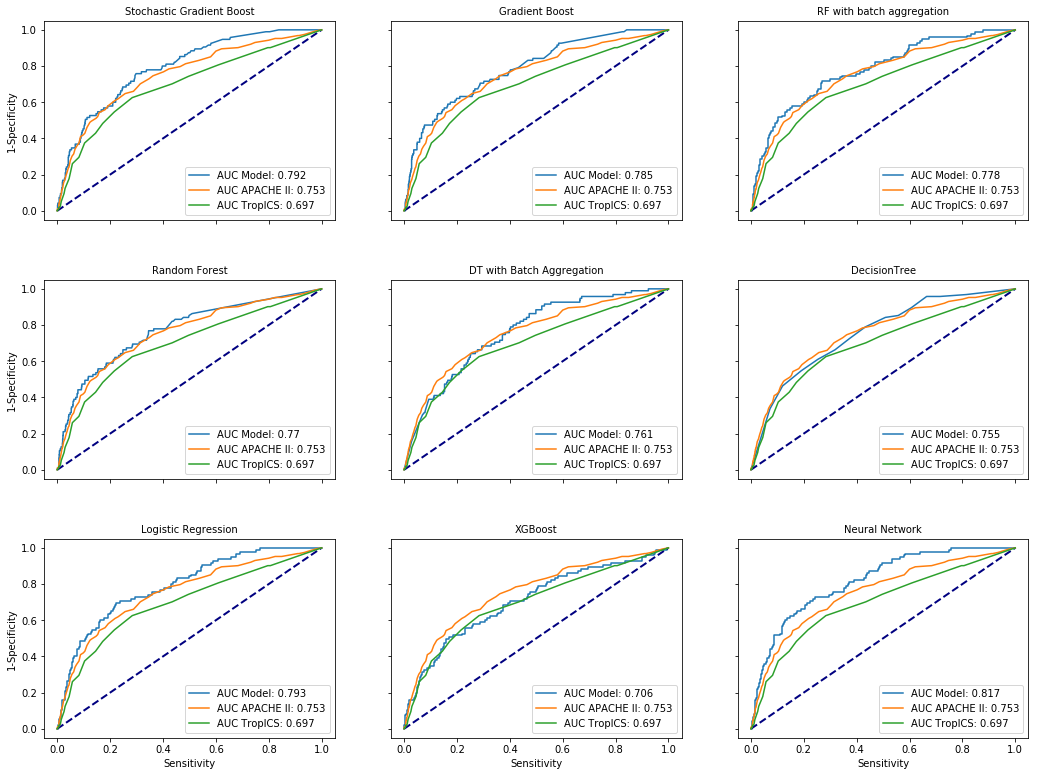

In [15]:
case_tr = preprocess.evaluate(pred_train, targ_train).testPerformance(data_type='test', 
                                                              models=models, ap_tr_list=apache_trop)

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.8005747479714778
Confidence interval for the score: [0.747 - 0.854]
Optimal threshold in training set is: 0.125
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.7874200885173346
Confidence interval for the score: [0.733 - 0.844]
Optimal threshold in training set is: 0.083
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.7937361691664618
Confidence interval for the score: [0.740 - 0.847]
Optimal threshold in training set is: 0.106
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.7658747233833292
Confidence interval for the score: [0.704 - 0.828]
Optimal threshold in training set is: 0.112
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.7878196459306614
Confidence interval fo

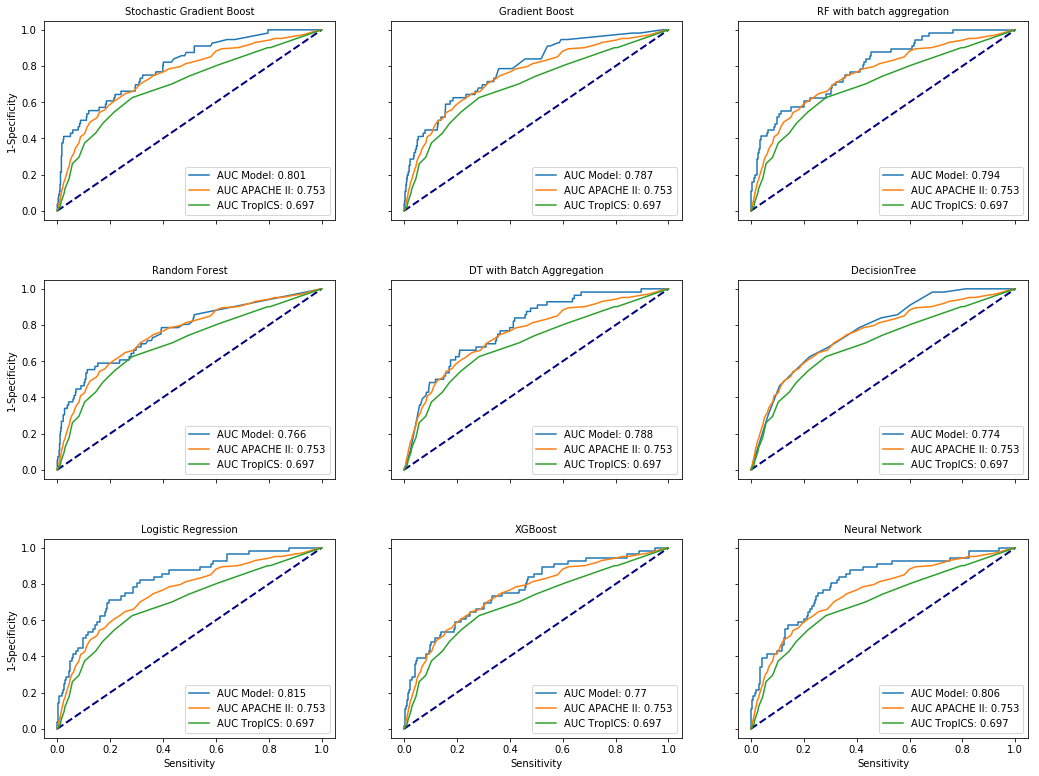

In [16]:
case_tr = preprocess.evaluate(pred_h, targ_h).testPerformance(data_type='holdout', 
                                                              models=models, ap_tr_list=apache_trop)

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Preparing dataset...
Evaluating...

Estimator: Random Forest
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Preparing dataset...
Evaluating...

Estimator: DecisionTree
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Preparing dataset...
Evaluating...

Estimator: XGBoost
Preparing dataset...
Evaluating...

Estimator: Neural Network


[]

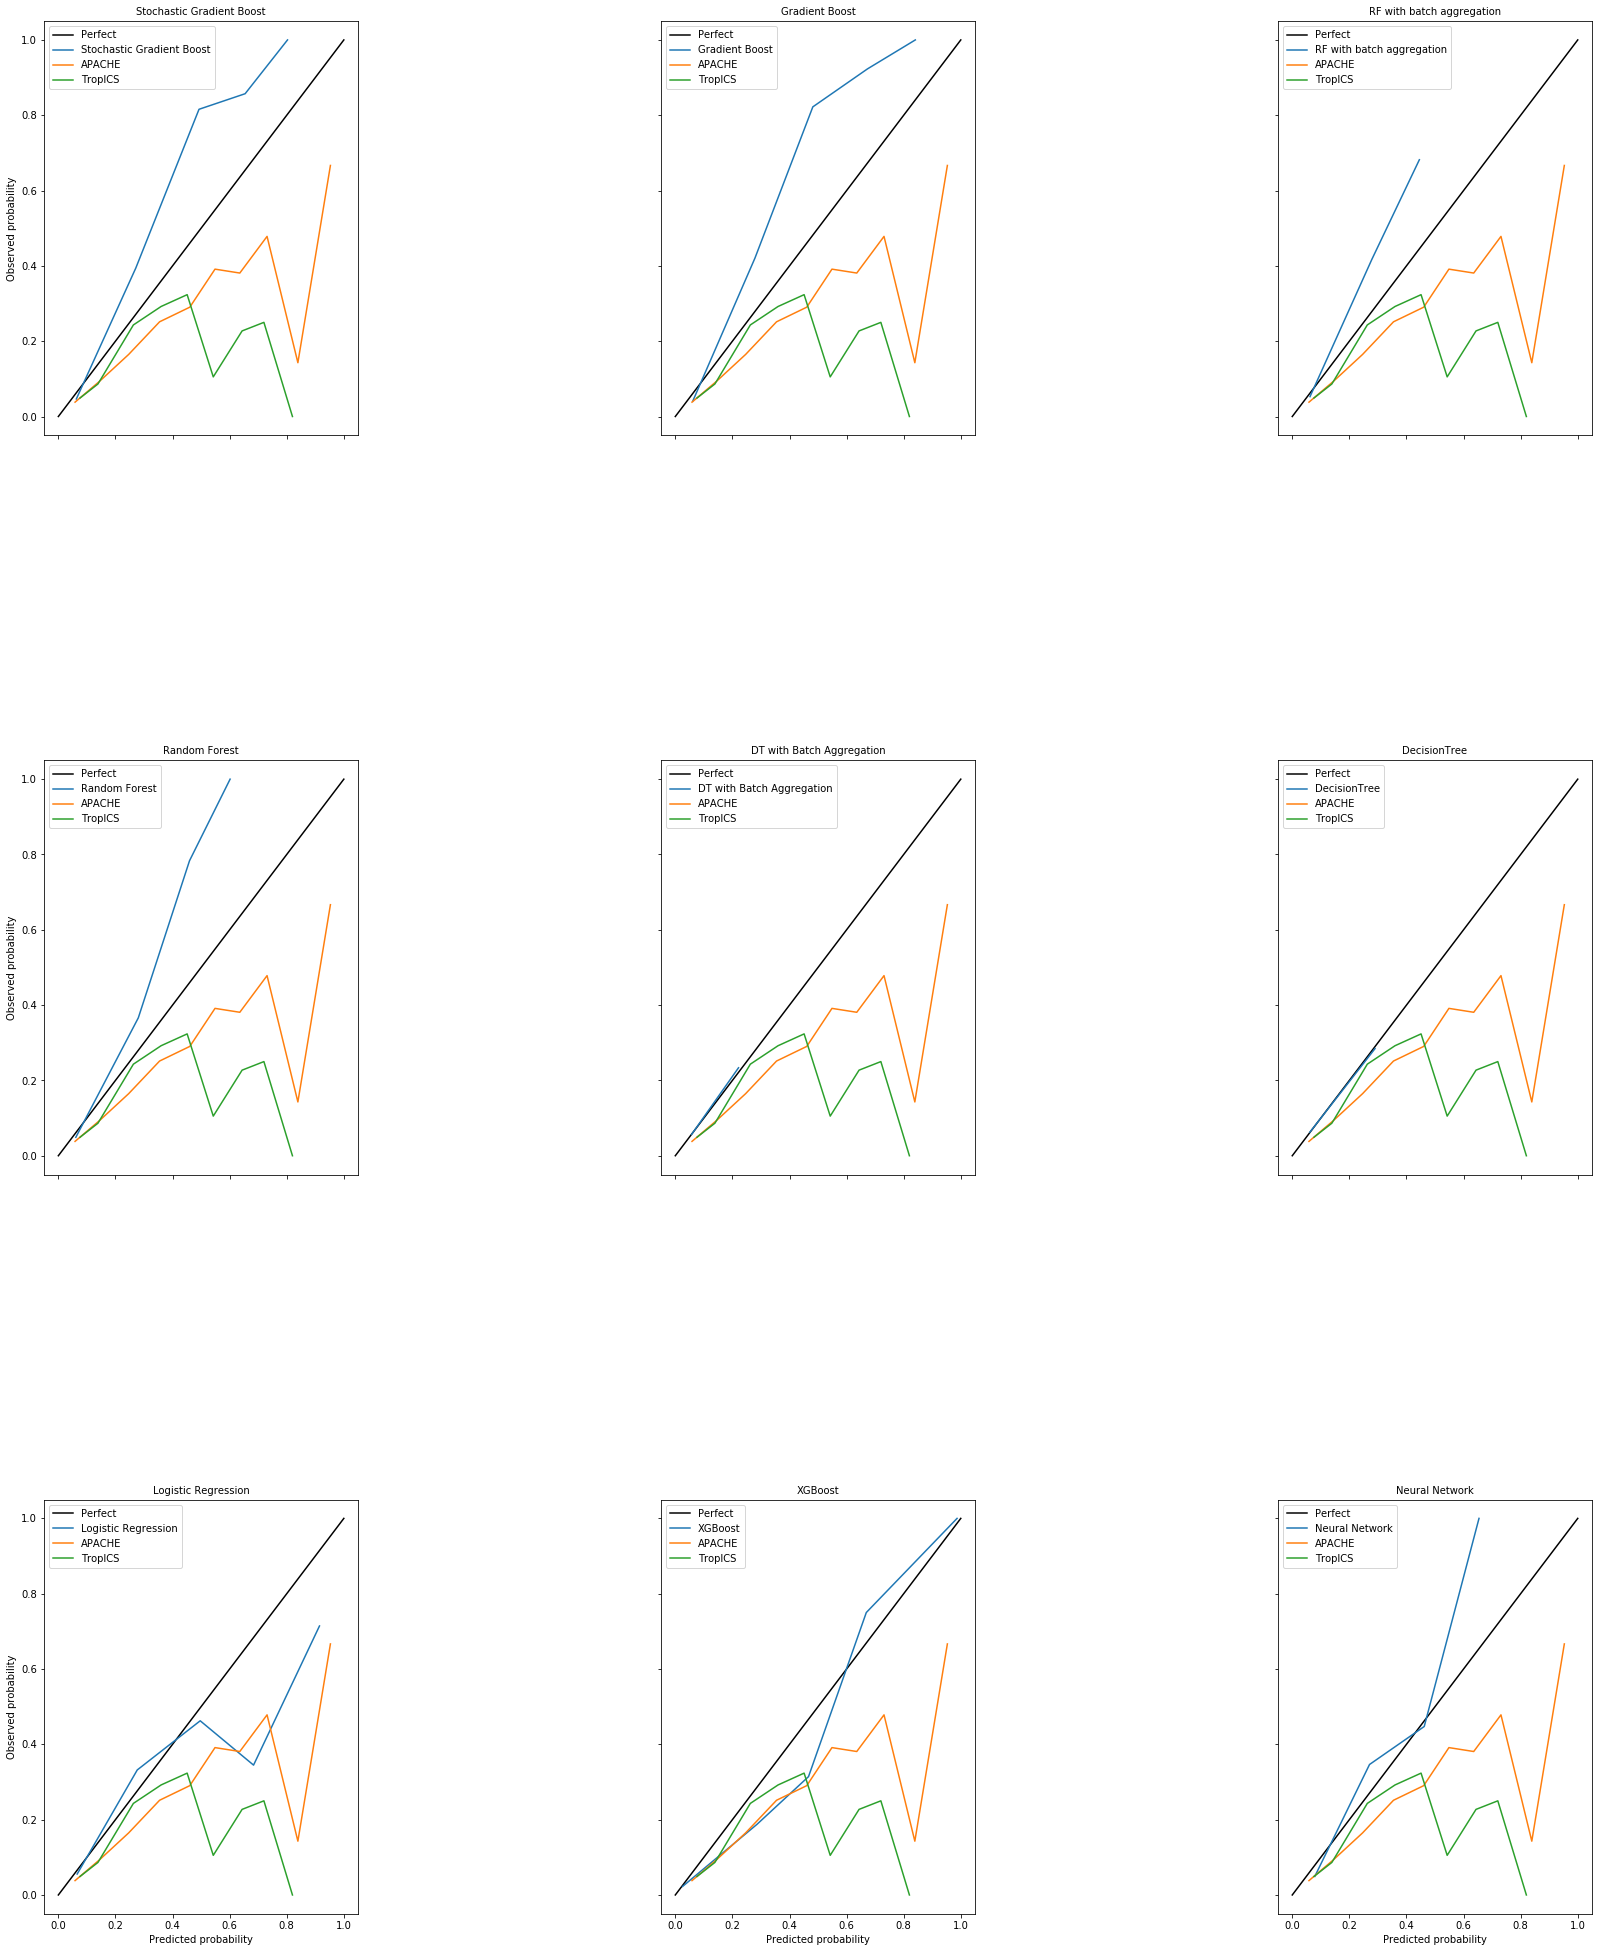

In [44]:
getCalibCurves(pred_train, targ_train, data_type='train', models=models, ap_tr_list=apache_trop)

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Preparing dataset...
Evaluating...

Estimator: Random Forest
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Preparing dataset...
Evaluating...

Estimator: DecisionTree
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Preparing dataset...
Evaluating...

Estimator: XGBoost
Preparing dataset...
Evaluating...

Estimator: Neural Network


[]

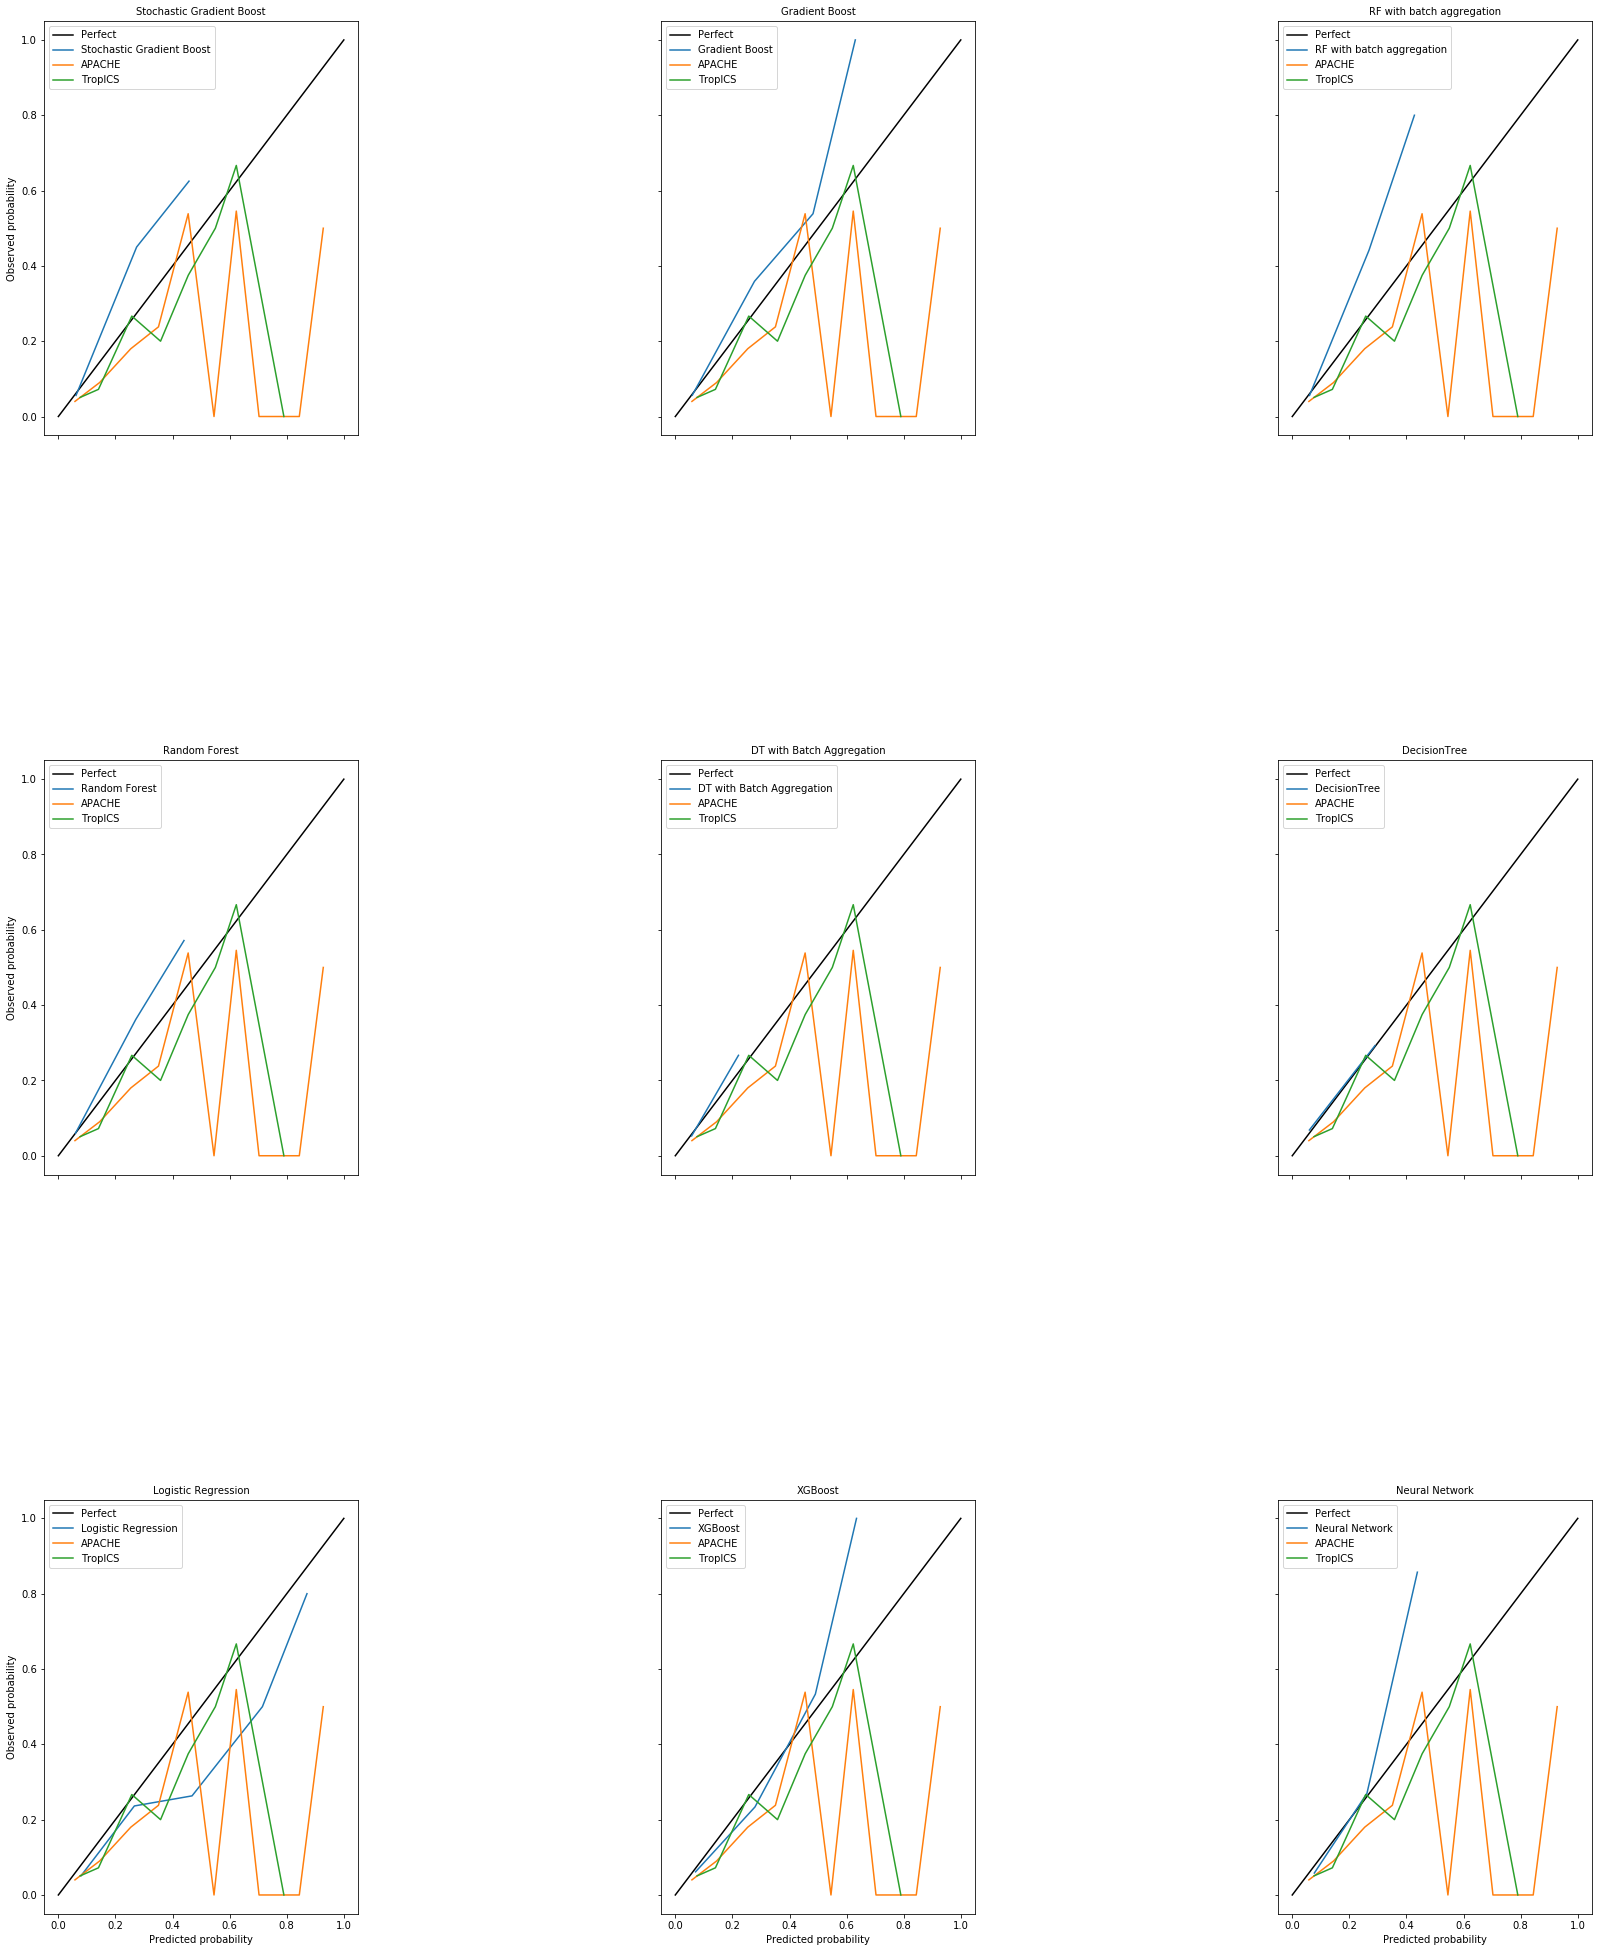

In [45]:
getCalibCurves(pred_h, targ_h, data_type='holdout', models=models, ap_tr_list=apache_trop_h)